# Calculating structure and properties of pristine 2D materials
a tutorial by Anne Marie Tan

Some things to note before we get started:
* Download the python scripts from the [github repository](https://github.com/aztan2/charged-defects-framework) and place them in the same directory as this notebook on hipergator.
* You will need to launch this notebook from a virtual environment on hipergator in which you have installed python packages like numpy, matplotlib, pymatgen, pandas, nglview (if you want to use the built-in crystal viewer), and of course jupyterlab.
* Follow the instructions in the [document on the Hennig group google drive](https://drive.google.com/file/d/15qzXZkK6Wrmor-9JOuGI_-nMmcHZsAoe/view?usp=sharing) to start a Jupyter notebook within a SLURM job on hipergator and connect to it from the web browser running on your local computer.
* For the purpose of this tutorial, I will try to keep everything self-contained by executing all commands within python, including navigating directories, executing python scripts, etc. \
However, when you actually apply this to a new system, you will probably find it easier to do some of these directly from command line. \
Hence, I will also include as comments the corresponding bash commands to perform certain steps.

Before getting into the defects, let’s start by computing some properties of the pristine monolayer, namely lattice constants, band gaps, and dielectric tensor. 

In [30]:
import os
import sys
import importlib
import pymatgen

In [31]:
import myutils
import gen_unitcell_2d
import gen_incar
import gen_kpts_grid
import gen_kpts_line
import gen_submit

#importlib.reload(myutils)
#importlib.reload(gen_unitcell_2d)
#importlib.reload(gen_incar)

### 1.      Check convergence of energy, lattice constants w.r.t. vacuum spacing:

* Obtain structure POSCAR from https://materialsproject.org. \
For this exercise, we'll use the example of MoS$_2$. The layered bulk structure can be found at https://materialsproject.org/materials/mp-2815/. \
Download the POSCAR file, rename it as POSCAR_bulk and place it in an appropriately-named directory on hipergator, such as `/ufrc/hennig/yourusername/MoS2/unitcell`. \
Enter this directory, replacing the path below with the path to your directory.

In [32]:
## Jupyter notebook has some built-in "magic commands" to execute certain bash commands such as cd or ls
%cd /ufrc/hennig/annemarietan/test/MoS2/unitcell

/ufrc/hennig/annemarietan/test/MoS2/unitcell


In [33]:
%ls

POSCAR_bulk    POSCAR_vac_15  vac_10/  vac_14/  vac_16/  vac_20/
POSCAR_vac_10  POSCAR_vac_20  vac_12/  vac_15/  vac_18/


I embedded a simple crystal structure viewer in this notebook, but you can also open this POSCAR in your favourite software and have a look at it. It should be a 6-atom unitcell of the layered bulk MoS$_2$.

In [63]:
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.vasp import Poscar

structure = Poscar.from_file('POSCAR_bulk').structure
atoms = AseAtomsAdaptor.get_atoms(structure)
ngl_handler = view(atoms, viewer='ngl')
ngl_handler.view.add_representation('ball+stick', selection='all')
ngl_handler.view.center()
ngl_handler

Create POSCARs with different amounts of vacuum spacing, ranging from ~ 10 – 20 Å. 

In [64]:
for vacs in [10,12,14,15,16,18,20]:
    gen_unitcell_2d.main(["POSCAR_bulk", "%s"%vacs, "--from_bulk", "--slabmin", "0.0", "--slabmax", "0.5", "--zaxis", "c"])
## python gen_unitcell_2d.py POSCAR_bulk <vacs> --from_bulk --slabmin 0.0 --slabmax 0.5 --zaxis c

In [65]:
%ls

POSCAR_bulk    POSCAR_vac_15  vac_10/  vac_14/  vac_16/  vac_20/
POSCAR_vac_10  POSCAR_vac_20  vac_12/  vac_15/  vac_18/


As you should see above, this script has created new sub-directories called `vac_10`, `vac_12`, etc. \
Let's enter one of them to see what's inside.

In [66]:
%cd vac_12
%ls

/ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_12
INCAR  KPOINTS  POSCAR  POTCAR  submitVASP.sh


In [67]:
%cat POSCAR

Mo1 S2
1.0
3.192238 0.000000 0.000000
-1.596119 2.764559 0.000000
0.000000 0.000000 15.128327
Mo S
1 2
direct
0.666667 0.333333 0.500000 Mo
0.333333 0.666667 0.603393 S
0.333333 0.666667 0.396607 S


Using the simple crystal structure viewer again, you should see that you now have a 3-atom unitcell of the MoS$_2$ monolayer surrounded by vaccum.

In [72]:
#from ase.visualize import view
#from pymatgen.io.ase import AseAtomsAdaptor
#from pymatgen.io.vasp import Poscar

structure = Poscar.from_file('POSCAR').structure
atoms = AseAtomsAdaptor.get_atoms(structure)
ngl_handler = view(atoms, viewer='ngl')
ngl_handler.view.add_representation('ball+stick', selection='all')
ngl_handler.view.center()
ngl_handler

* Prepare the POTCAR by concatenating the appropriate element POTCARs. \
We usually use the pseudopotentials suggested by materialsproject. 
So, in this case, we will use the `Mo_pv` POTCAR for Mo and `S` POTCAR for S. \
Note that pymatgen orders the elements in the POSCAR by increasing electronegativity, hence the element POTCARs must be concatenated in the same order.

In [73]:
%cat /home/annemarietan/POTCAR/POT_GGA_PAW_PBE/Mo_pv/POTCAR /home/annemarietan/POTCAR/POT_GGA_PAW_PBE/S/POTCAR > POTCAR
%ls

INCAR  KPOINTS  POSCAR  POTCAR  submitVASP.sh


* Prepare INCAR for a standard structural relaxation run, but with ISIF = 3 to relax cell parameters as well to get the equilibrium lattice constnt.

In [74]:
gen_incar.main(["--functional", "PBE", "--runtype", "relax", "--relaxcell"])
## python gen_incar.py --funtional PBE --runtype relax --relaxcell

In [75]:
%cat INCAR

PREC = Accurate
ALGO = Fast
LREAL = Auto
ISYM = 0
NELECT = 24
ENCUT = 520
NELM = 120
EDIFF = 1e-06
ISIF = 3
IBRION = 2
NSW = 100
ISMEAR = 1
SIGMA = 0.1
ISPIN = 2
MAGMOM = 1*5.0 2*0.6
LPLANE = True
LWAVE = False
LCHARG = True
LMAXMIX = 4
LORBIT = 11
LVTOT = True
LVHAR = True


* Prepare KPOINTS. 
For 2D materials, we decided on kpts per reciprocal atom (p.r.a.) > 400. 
Typically, I try to choose a value of kpts p.r.a. that gives me an easily divisible mesh size, e.g. 12x12x1

In [76]:
gen_kpts_grid.main(["--kppa", "440"])
## python gen_kpts_grid.py --kppa 440

In [77]:
%cat KPOINTS

automatically generated KPOINTS with 2d grid density = 440 per reciprocal atom
0
Gamma
12 12 1


* Prepare the submission script. For now, you may leave the queue/nodes/memory/time at their default values, but remember to change the email option to *YOUR* email address! In fact, you may want to just change the default in the `gen_submit.py` script itself. 

In [78]:
gen_submit.main(["--jobname", "MoS2_unitcell", "--email", "youremail@ufl.edu", "--time", "6:00:00"])
## python gen_submit.py --jobname MoS2_unitcell --email youremail@ufl.edu --time 6:00:00

MoS2_unitcell


In [79]:
%cat submitVASP.sh

#!/bin/bash
#SBATCH --job-name=MoS2_unitcell
#SBATCH -o out_%j
#SBATCH -e err_%j
#SBATCH --mail-type=END,FAIL  # Mail events (NONE, BEGIN, END, FAIL, ALL)
#SBATCH --mail-user=youremail@ufl.edu
#SBATCH --partition=hpg2-compute
#SBATCH --qos=hennig
#SBATCH --ntasks=32
#SBATCH --ntasks-per-socket=16
#SBATCH --ntasks-per-node=32
#SBATCH --nodes=1
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu=2048mb
#SBATCH -t 6:00:00
#SBATCH --distribution=cyclic:cyclic

cd $SLURM_SUBMIT_DIR

module purge
module load intel/2019.1.144
module load openmpi/4.0.1
srun --mpi=pmix_v3 /home/annemarietan/vasp5.4.4_intel2019/vasp_noz > job.log

echo 'Done.'

In [80]:
%ls

INCAR  KPOINTS  POSCAR  POTCAR  submitVASP.sh


* You should have a POSCAR, POTCAR, INCAR, KPOINTS, and submitVASP.sh file in this directory now. \
Go ahead and submit your job by typing `sbatch submitVASP.sh` on hipergator!

* Now, let's go back and do the same in all the other `vac_<>` subdirectories. You can either re-run all the commands/scripts to generate the POTCAR, INCAR, KPOINTS and submitVASP.sh again, or simply copy them from this directory into all the others. (All of these calculations will use the same VASP input files except for the POSCARs which have different vacuum spacings.)

In [81]:
%cd /ufrc/hennig/annemarietan/test/MoS2/unitcell
%cp vac_12/{INCAR,KPOINTS,POTCAR,submitVASP.sh} vac_10/
%cp vac_10/{INCAR,KPOINTS,POTCAR,submitVASP.sh} vac_14/
%cp vac_10/{INCAR,KPOINTS,POTCAR,submitVASP.sh} vac_16/
%cp vac_10/{INCAR,KPOINTS,POTCAR,submitVASP.sh} vac_18/
%cp vac_10/{INCAR,KPOINTS,POTCAR,submitVASP.sh} vac_20/

/ufrc/hennig/annemarietan/test/MoS2/unitcell


**EXERCISE**: When your jobs are completed, plot out:
* final energy (where to find the final energy?) vs. vacuum spacing
* in-plane lattice constant vs. vacuum spacing

Do you observe convergence of these quantities with increasing vacuum spacing? How do your values compare with those reported in literature?

### 2.      Next, we would like to calculate the band structure of the pristine monolayer:

* Enter one of the directories from before and create a subdirectory in it called `bands`.

In [82]:
%cd /ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10
%mkdir bands
%cd bands

/ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10
mkdir: cannot create directory ‘bands’: File exists
/ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10/bands


* Copy the CONTCAR from the converged structural relaxation run and rename it POSCAR. 
Also copy the CHGCAR, POTCAR and submission script into the new directory.

In [83]:
%cp ../CONTCAR POSCAR
%cp ../CHGCAR .
%cp ../{POTCAR,submitVASP.sh} .
%ls

CHGCAR  INCAR  KPOINTS  POSCAR  POTCAR  submitVASP.sh


* We need to generate a new INCAR file with a few different tags for the band structure calculation: \
`IBRION = -1` and `NSW = 0` specify that only a single ionic step will be performed. \
If a CHGCAR or WAVECAR is provided, `ICHARG = 11` or `ICHARG = 10` specify that a non-selfconsistent calculation will be performed, meaning that the charge density will be kept constant throughout the calculation.

In [84]:
gen_incar.main(["--functional", "PBE", "--runtype", "bands"])
## python gen_incar.py --funtional PBE --runtype bands

In [85]:
%cat INCAR

PREC = Accurate
ALGO = Fast
LREAL = Auto
ICHARG = 11
ISYM = 0
NELECT = 24
ENCUT = 520
NELM = 120
EDIFF = 1e-06
ISIF = 2
IBRION = -1
NSW = 0
ISMEAR = 1
SIGMA = 0.1
ISPIN = 2
MAGMOM = 1*5.0 2*0.6
LPLANE = True
NPAR = 4
KPAR = 2
LWAVE = False
LCHARG = False
LMAXMIX = 4
LORBIT = 11
LVTOT = True
LVHAR = True


* For the band structure calculation, we need to specify a different type of KPOINTS file. Instead of specifying a uniform k-point grid, we specify a high symmetry path along which we want to evaluate the band structure. The choice of high symmetry path depends on the symmetry inherent to that crystal structure, and is determined using a procedure developed by [Setyawan and Curtarolo](https://arxiv.org/abs/1004.2974). \
For a 2D hexagonal structure such as MoS$_2$, the relevant high symmetry path passes through the points Γ-M-K-Γ. You can visualize the kpath using [this online tool](http://materials.duke.edu/awrapper.html). You should get something that looks like this:

<div>
<img src="tutorial_images/kpath.png" width="300"/>
</div>

In [88]:
gen_kpts_line.main(["--ndiv", "20", "--dim", "2"])
## python gen_kpts_line.py --ndiv 20 --dim 2

In [89]:
%mv KPOINTS_bands KPOINTS
%cat KPOINTS

Line_mode KPOINTS file
20
Line_mode
Reciprocal
0.0 0.0 0.0 ! \Gamma
0.5 0.0 0.0 ! M

0.5 0.0 0.0 ! M
0.3333333333333333 0.3333333333333333 0.0 ! K

0.3333333333333333 0.3333333333333333 0.0 ! K
0.0 0.0 0.0 ! \Gamma



* You should have (at least) a POSCAR, POTCAR, INCAR, KPOINTS, and submitVASP.sh file in this directory now.
Go ahead and submit your job!

**EXERCISE**: When your job is completed, plot the band structure diagram using the following script:

/ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10/bands_ref


/home/annemarietan/miniconda3/envs/jupyter/lib/python3.7/site-packages/pymatgen/io/vasp/inputs.py:1859: BadPotcarWarning: POTCAR with symbol Mo_pv has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_54', 'PBE_52', 'unvie_PBE_52']
  BadPotcarWarning)
/home/annemarietan/miniconda3/envs/jupyter/lib/python3.7/site-packages/pymatgen/io/vasp/inputs.py:1859: BadPotcarWarning: POTCAR with symbol S has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_54', 'PBE_52', 'unvie_PBE_52']
  BadPotcarWarning)


Band gap:  {'direct': False, 'energy': 1.6741000000000001, 'transition': '\\Gamma-K'}


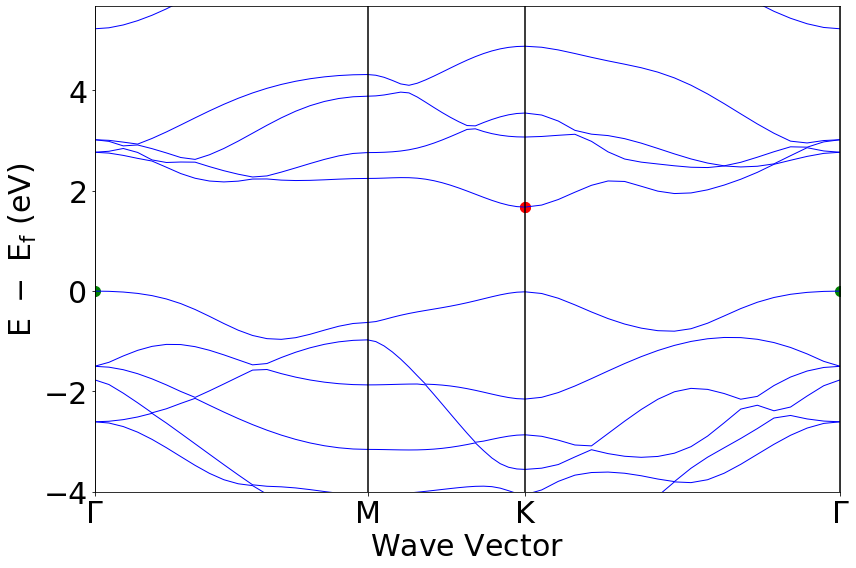

In [92]:
#%cd /ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10/bands_ref

import matplotlib
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import BSPlotter
run = Vasprun("vasprun.xml",parse_projected_eigen=False)
bs = run.get_band_structure("KPOINTS",line_mode=True)
print("Band gap: ",bs.get_band_gap())
bsplot = BSPlotter(bs)
bs.is_spin_polarized = False
bsplot.get_plot(zero_to_efermi=True,vbm_cbm_marker=True).savefig("bandstructure.png")

* Repeat this calculation for other vacuum spacings as well. \
Do you observe a strong dependence of the band structure and band gap with vacuum spacing? How does your band structure compare with that reported in literature?

### 3.      Now for the dielectric tensor:

* Enter one of the directories from before and create a subdirectory in it called `dielectric`.

In [94]:
%cd /ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10
%mkdir dielectric
%cd dielectric

/ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10
/ufrc/hennig/annemarietan/test/MoS2/unitcell/vac_10/dielectric


* Copy the CONTCAR from the converged structural relaxation run and rename it POSCAR. \
Also copy the KPOINTS, POTCAR and submission script into the new directory.

In [95]:
%cp ../CONTCAR POSCAR
%cp ../{KPOINTS,POTCAR,submitVASP.sh} .
%ls

KPOINTS  POSCAR  POTCAR  submitVASP.sh


* We need to generate a new INCAR file with a few different tags for the dielectric tensor calculation: \
`LEPSILON = True` and `LPEAD = True` determine the static (ion-clamped) dielectric matrix using density functional perturbation theory, while  `IBRION = 6` determines the ionic contribution to the dielectric tensor by finite differences.

In [96]:
gen_incar.main(["--functional", "PBE", "--runtype", "dielectric"])
## python gen_incar.py --funtional PBE --runtype dielectric

In [97]:
%cat INCAR

PREC = Accurate
ALGO = Fast
LREAL = Auto
NELECT = 24
ENCUT = 520
NELM = 120
EDIFF = 1e-06
ISIF = 2
IBRION = 6
NSW = 100
ISMEAR = 1
SIGMA = 0.1
ISPIN = 2
MAGMOM = 1*5.0 2*0.6
LPLANE = True
LWAVE = False
LCHARG = False
LMAXMIX = 4
LORBIT = 11
LEPSILON = True
LPEAD = True


* You should have a POSCAR, POTCAR, INCAR, KPOINTS, and submitVASP.sh file in this directory now. Go ahead and submit your job!
* Repeat this calculation for other vacuum spacings as well.

**EXERCISE**: The electronic contribution to the dielectric tensor is reported in the OUTCAR under the heading `MACROSCOPIC STATIC DIELECTRIC TENSOR (including local field effects in DFT)` and the ionic contribution under the heading `MACROSCOPIC STATIC DIELECTRIC TENSOR IONIC CONTRIBUTION`. Sum these two tensors up to obtain the total dielectric response of the system. \
What do you observe? Does the dielectric tensor converge with vacuum spacing?

* You should find that, unlike the previous quantities, the dielectric tensor does **not** converge with vacuum spacing.
This is actually to be expected in this case because VASP calculates the total dielectric response of the entire system that includes the slab of interest + vacuum spacing.
As a result, the dielectric tensor values that we obtain from the OUTCAR are not the dielectric tensor of just our slab, but some combination of the dielectric tensor of the slab and the vacuum ($\varepsilon$ = 1).

* Therefore, we will estimate the dielectric tensor of our slab using the following model (see [Tan *et al*.](https://doi.org/10.1103/PhysRevMaterials.4.064004), [Freysoldt *et al*.](https://doi.org/10.1103/PhysRevB.77.235428)), in which we consider the in-plane components of the slab dielectric tensor to be in parallel with that of the vacuum, while the out-of-plane component of the slab dielectric tensor is in series with that of the vacuum:

<div>
<img src="tutorial_images/dielectric.png" width="300"/>
</div>

<div>
<img src="tutorial_images/eqn_dielectric_a.png" width="400"/>
</div>

where $d^{\textrm{vac}}$ = height of the vacuum spacing, $d^{\textrm{slab}}$ = height of the monolayer slab, $d^{\textrm{sc}}$ = height of the supercell = $d^{\textrm{vac}}$ + $d^{\textrm{slab}}$, $\varepsilon^{\textrm{sc}}_{\parallel}$ and $\varepsilon^{\textrm{sc}}_{\perp}$ are the (averaged) in-plane and out-of-plane components of the supercell dielectric tensor which you read from the VASP OUTCAR, and $\varepsilon^{\textrm{slab}}_{\parallel}$ and $\varepsilon^{\textrm{slab}}_{\perp}$ are the in-plane and out-of-plane components of the slab dielectric tensor.

* To simplify, let us assume an isotropic slab ($\varepsilon^{\textrm{slab}}_{\parallel} = \varepsilon^{\textrm{slab}}_{\perp}$). Then, we can rearrange the equations above to solve for the unknown quantities $\varepsilon^{\textrm{slab}}$ and $d^{\textrm{slab}}$:

<div>
<img src="tutorial_images/eqn_dielectric_b.png" width="300"/>
</div>

(Note: in the systems I've encountered so far, the off-diagonal components of the dielectric tensor were effectively zero; if this is not the case in your system, check with Richard!)

## SUMMARY

In this tutorial, you should have learnt how to:
* obtain the structure of a 2D monolayer from its layered bulk counterpart
* perform a structural relaxation to determine the equilibrium lattice constant(s)
* perform a band structure calculation to obtain the (PBE) band gap and band structure
* observe the convergence of these quantities as well as the total energy with vacuum spacing
* perform a dielectric tensor calculation and extract the slab dielectric tensor

Note down all these quantities; you will need them as we move on to the next tutorial: **"Calculations of charged defects in 2D materials"**.